**Research Question:** Does the emotional tone of films differ between movies in different languages?

Additionally, regression analysis will be used to explore connections between movie languages and emotional tones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 
import ast

sys.path.append("../")
from utils.methods import conv_to_dict

DATA_PATH = "../../data"

df = pd.read_csv(f"{DATA_PATH}/final_data_complete.csv")

In [2]:
# Look at the distribution of languages over all movies

# Convert the Languages column to a list
df["Languages"] = df["Languages"].apply(lambda x: ast.literal_eval(x))
df["nrclex_emotions"] = df["nrclex_emotions"].apply(lambda x: conv_to_dict(x))
df["roberta_emotions"] = df["roberta_emotions"].apply(lambda x: conv_to_dict(x))
df["distilbert_emotions"] = df["distilbert_emotions"].apply(lambda x: conv_to_dict(x))


In [3]:
# We were getting some errors printing languages and seems there are some invalid unicode characters
def is_invalid_unicode(text: str):
    """Check if text contains invalid unicode characters"""
    try:
        text.encode('utf-8').decode('utf-8')
        return False
    except UnicodeError:
        return True
    
def clean_lang_list(languages: list[str]):
    """Remove invalid languages from a list of languages"""
    return [l for l in languages if not is_invalid_unicode(l)]

df["Languages"] = df["Languages"].apply(clean_lang_list)


In [4]:
no_lang_count = len(df[df["Languages"].apply(lambda x: len(x) == 0)])
print(f"Number of movies with no language: {no_lang_count}")

# Percentage of movies with no language
print(f"Percentage of movies with no language: {no_lang_count / len(df) * 100:.2f}%")


Number of movies with no language: 13868
Percentage of movies with no language: 16.96%


In [5]:
# Drop all movies that don't have a labelled language
df[df["Languages"].apply(lambda x: len(x) < 0)]

# Look at the distribution of languages over all movies
language_count = df['Languages'].explode().value_counts()
print(language_count)

Languages
English Language                        40914
Hindi Language                           3745
Spanish Language                         3675
French Language                          3422
Silent film                              3183
                                        ...  
Australian Aboriginal Pidgin English        1
Krio Language                               1
Tok Pisin Language                          1
Pawnee Language                             1
Kriolu                                      1
Name: count, Length: 206, dtype: int64


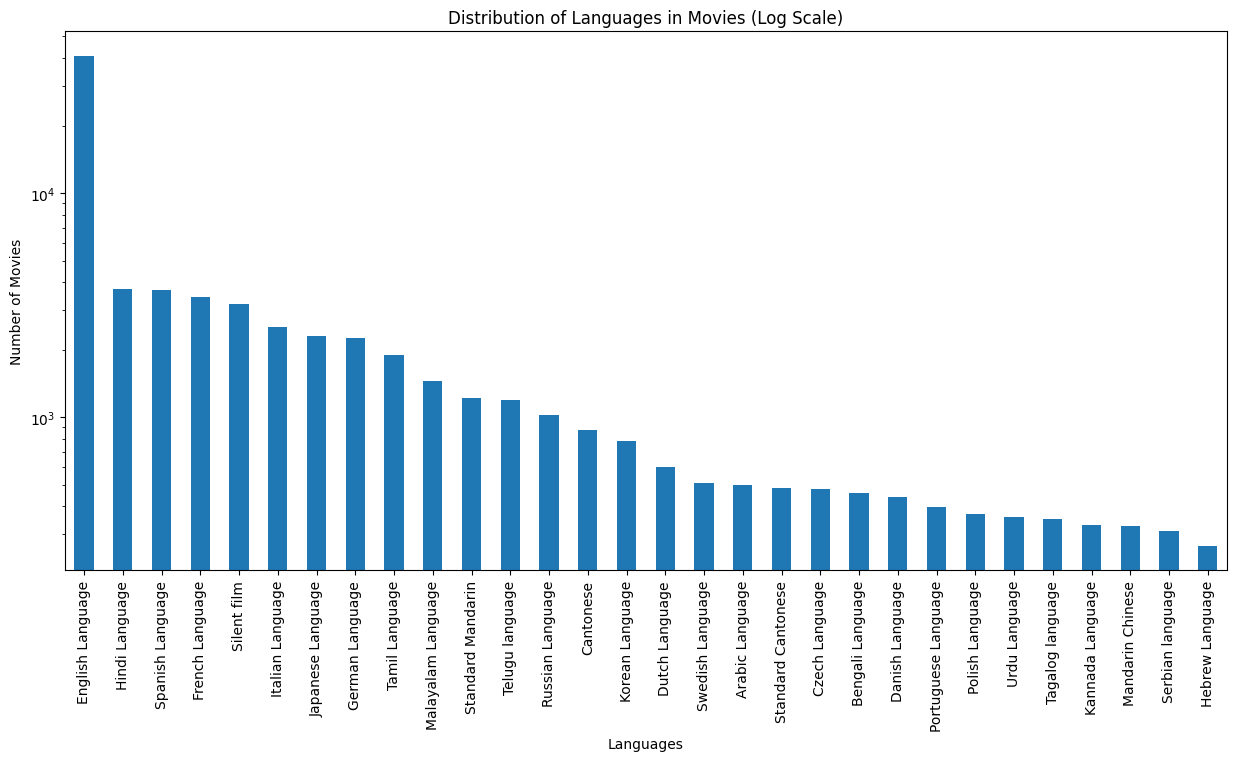

In [6]:
language_count[:30].plot(kind='bar', figsize=(15, 7), logy=True)
plt.title('Distribution of Languages in Movies (Log Scale)')
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.show()

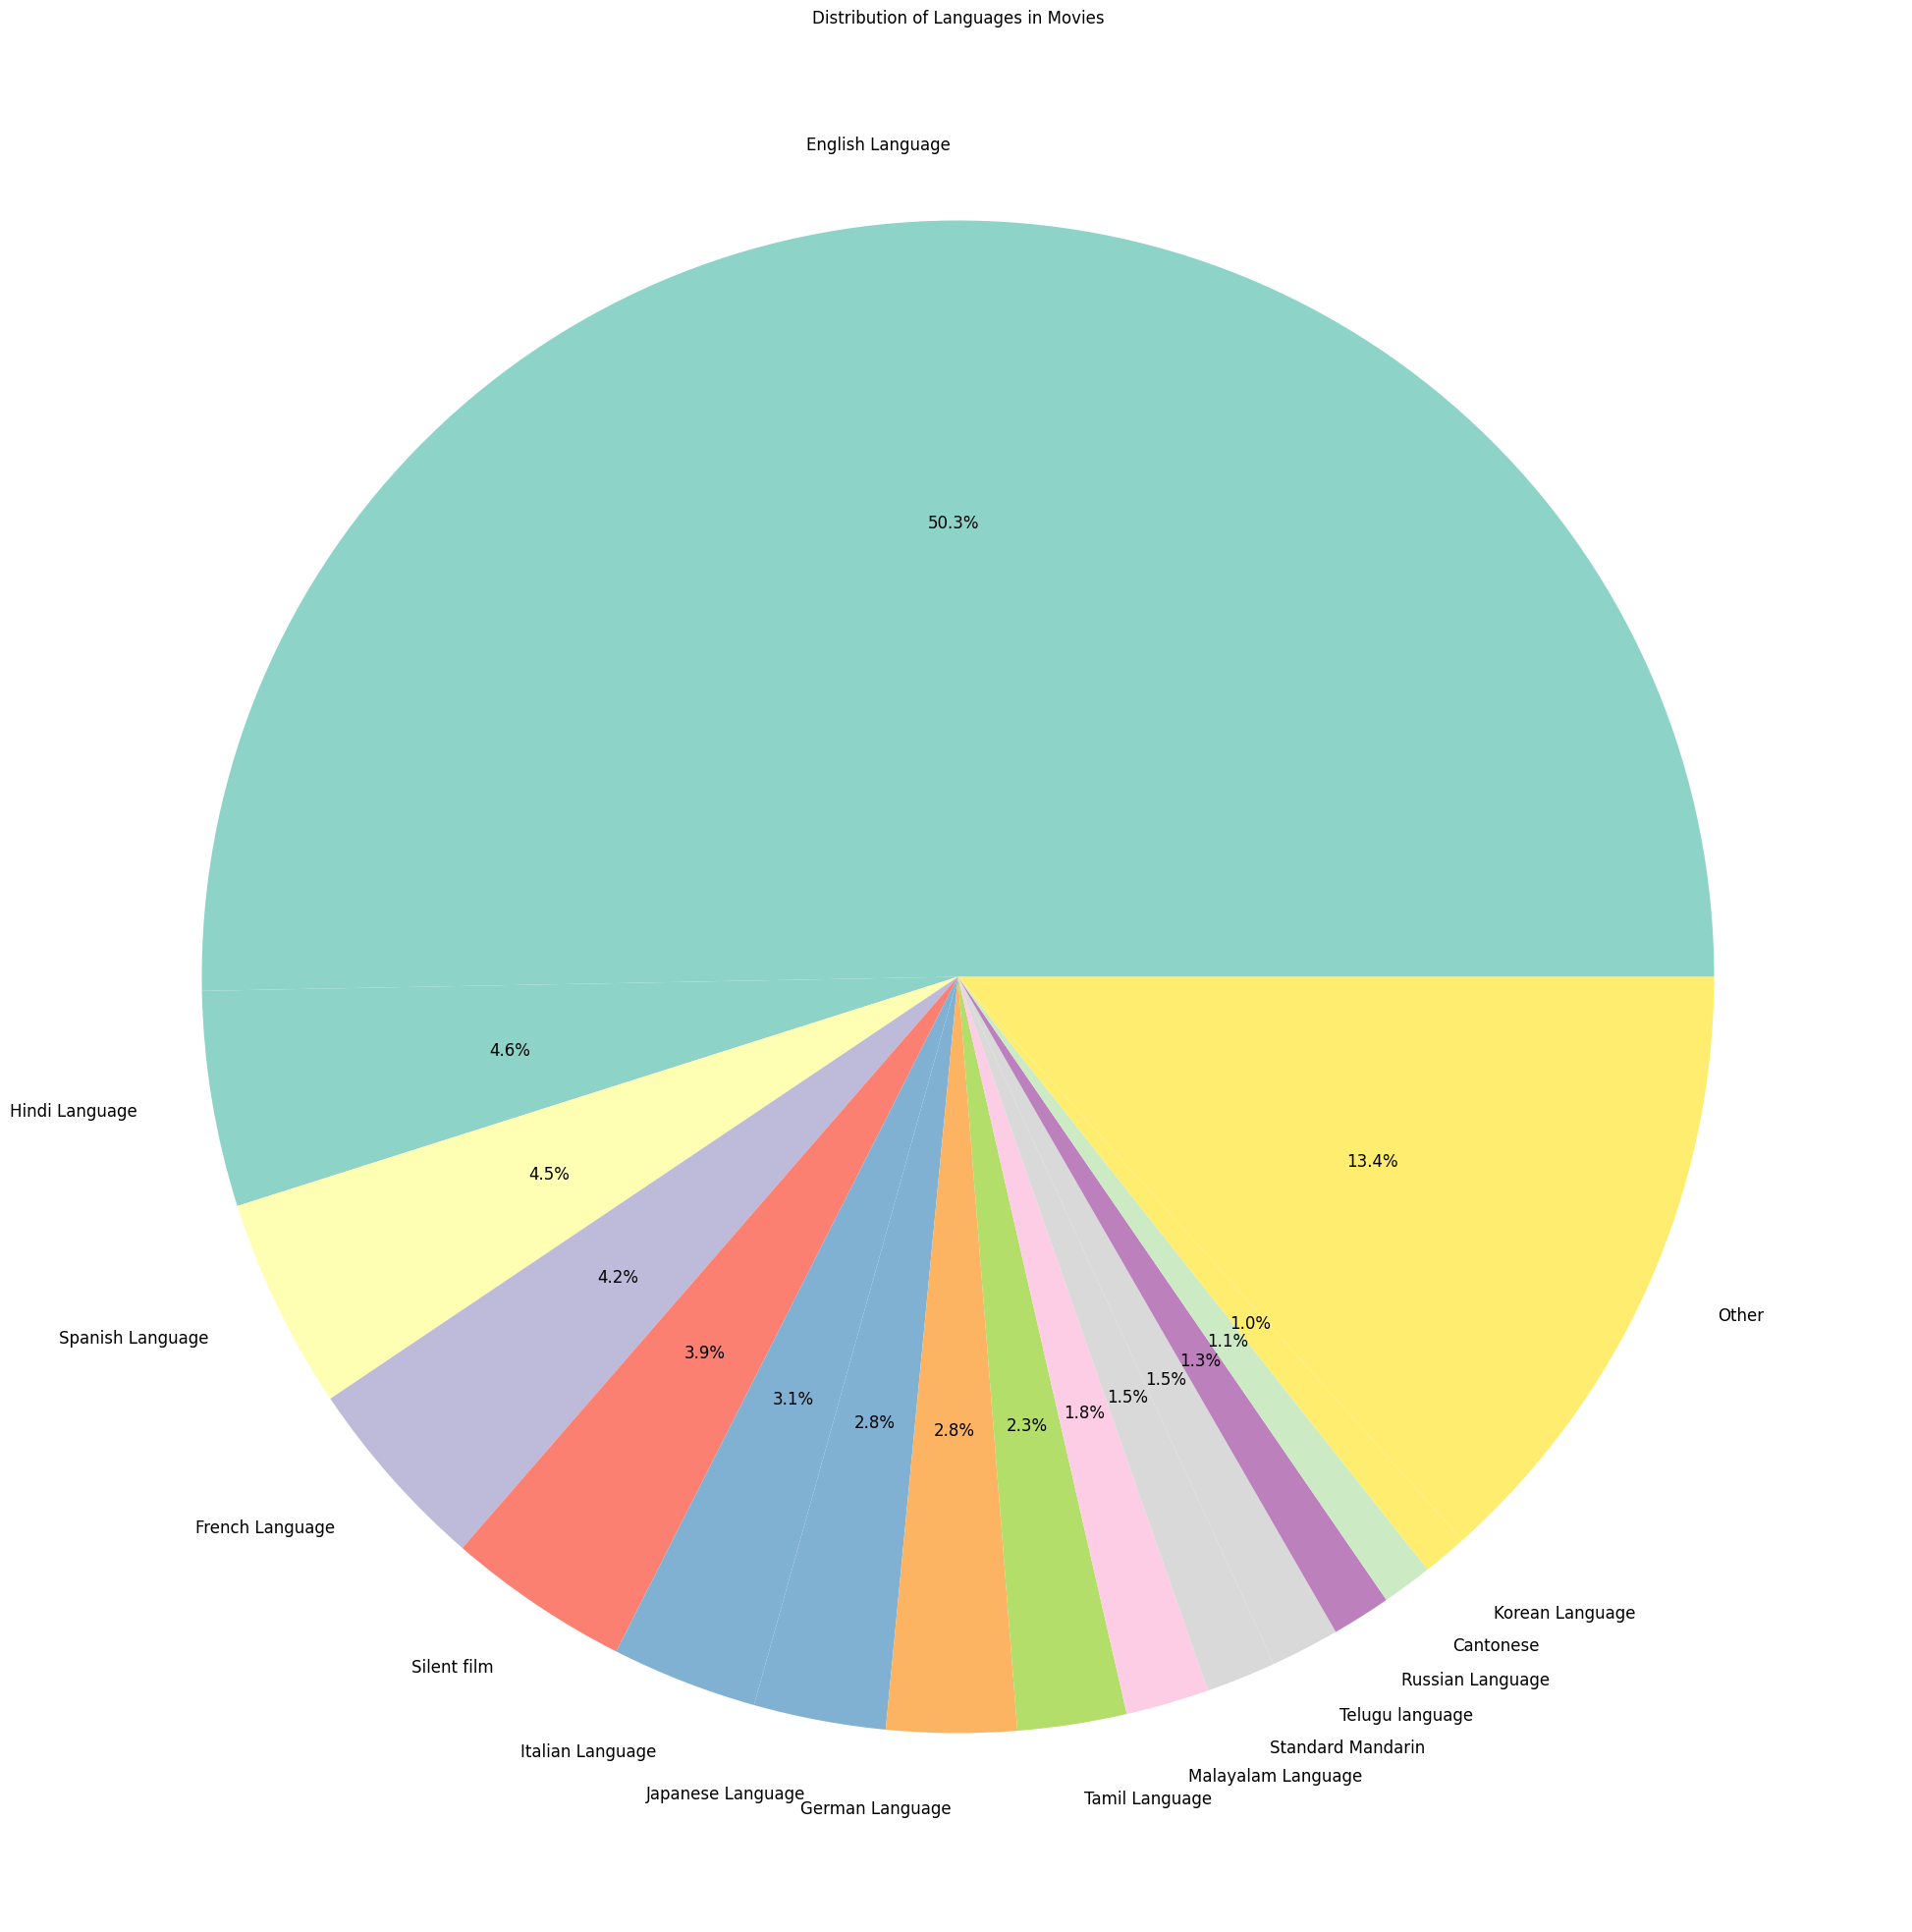

In [7]:
# Create a pie chart of the top 15 languages plus "Other"
plt.figure(figsize=(25, 25))

# Get top 15 languages and sum the rest into "Other"
top_15 = language_count[:15]
other = pd.Series({'Other': language_count[15:].sum()})
plot_data = pd.concat([top_15, other])

colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))

plt.pie(plot_data, labels=plot_data.index, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Distribution of Languages in Movies')
plt.show()

# As an explicit choice, we will keep silent films going forward because there may be some emotional profile differences for films with NO dialoguej

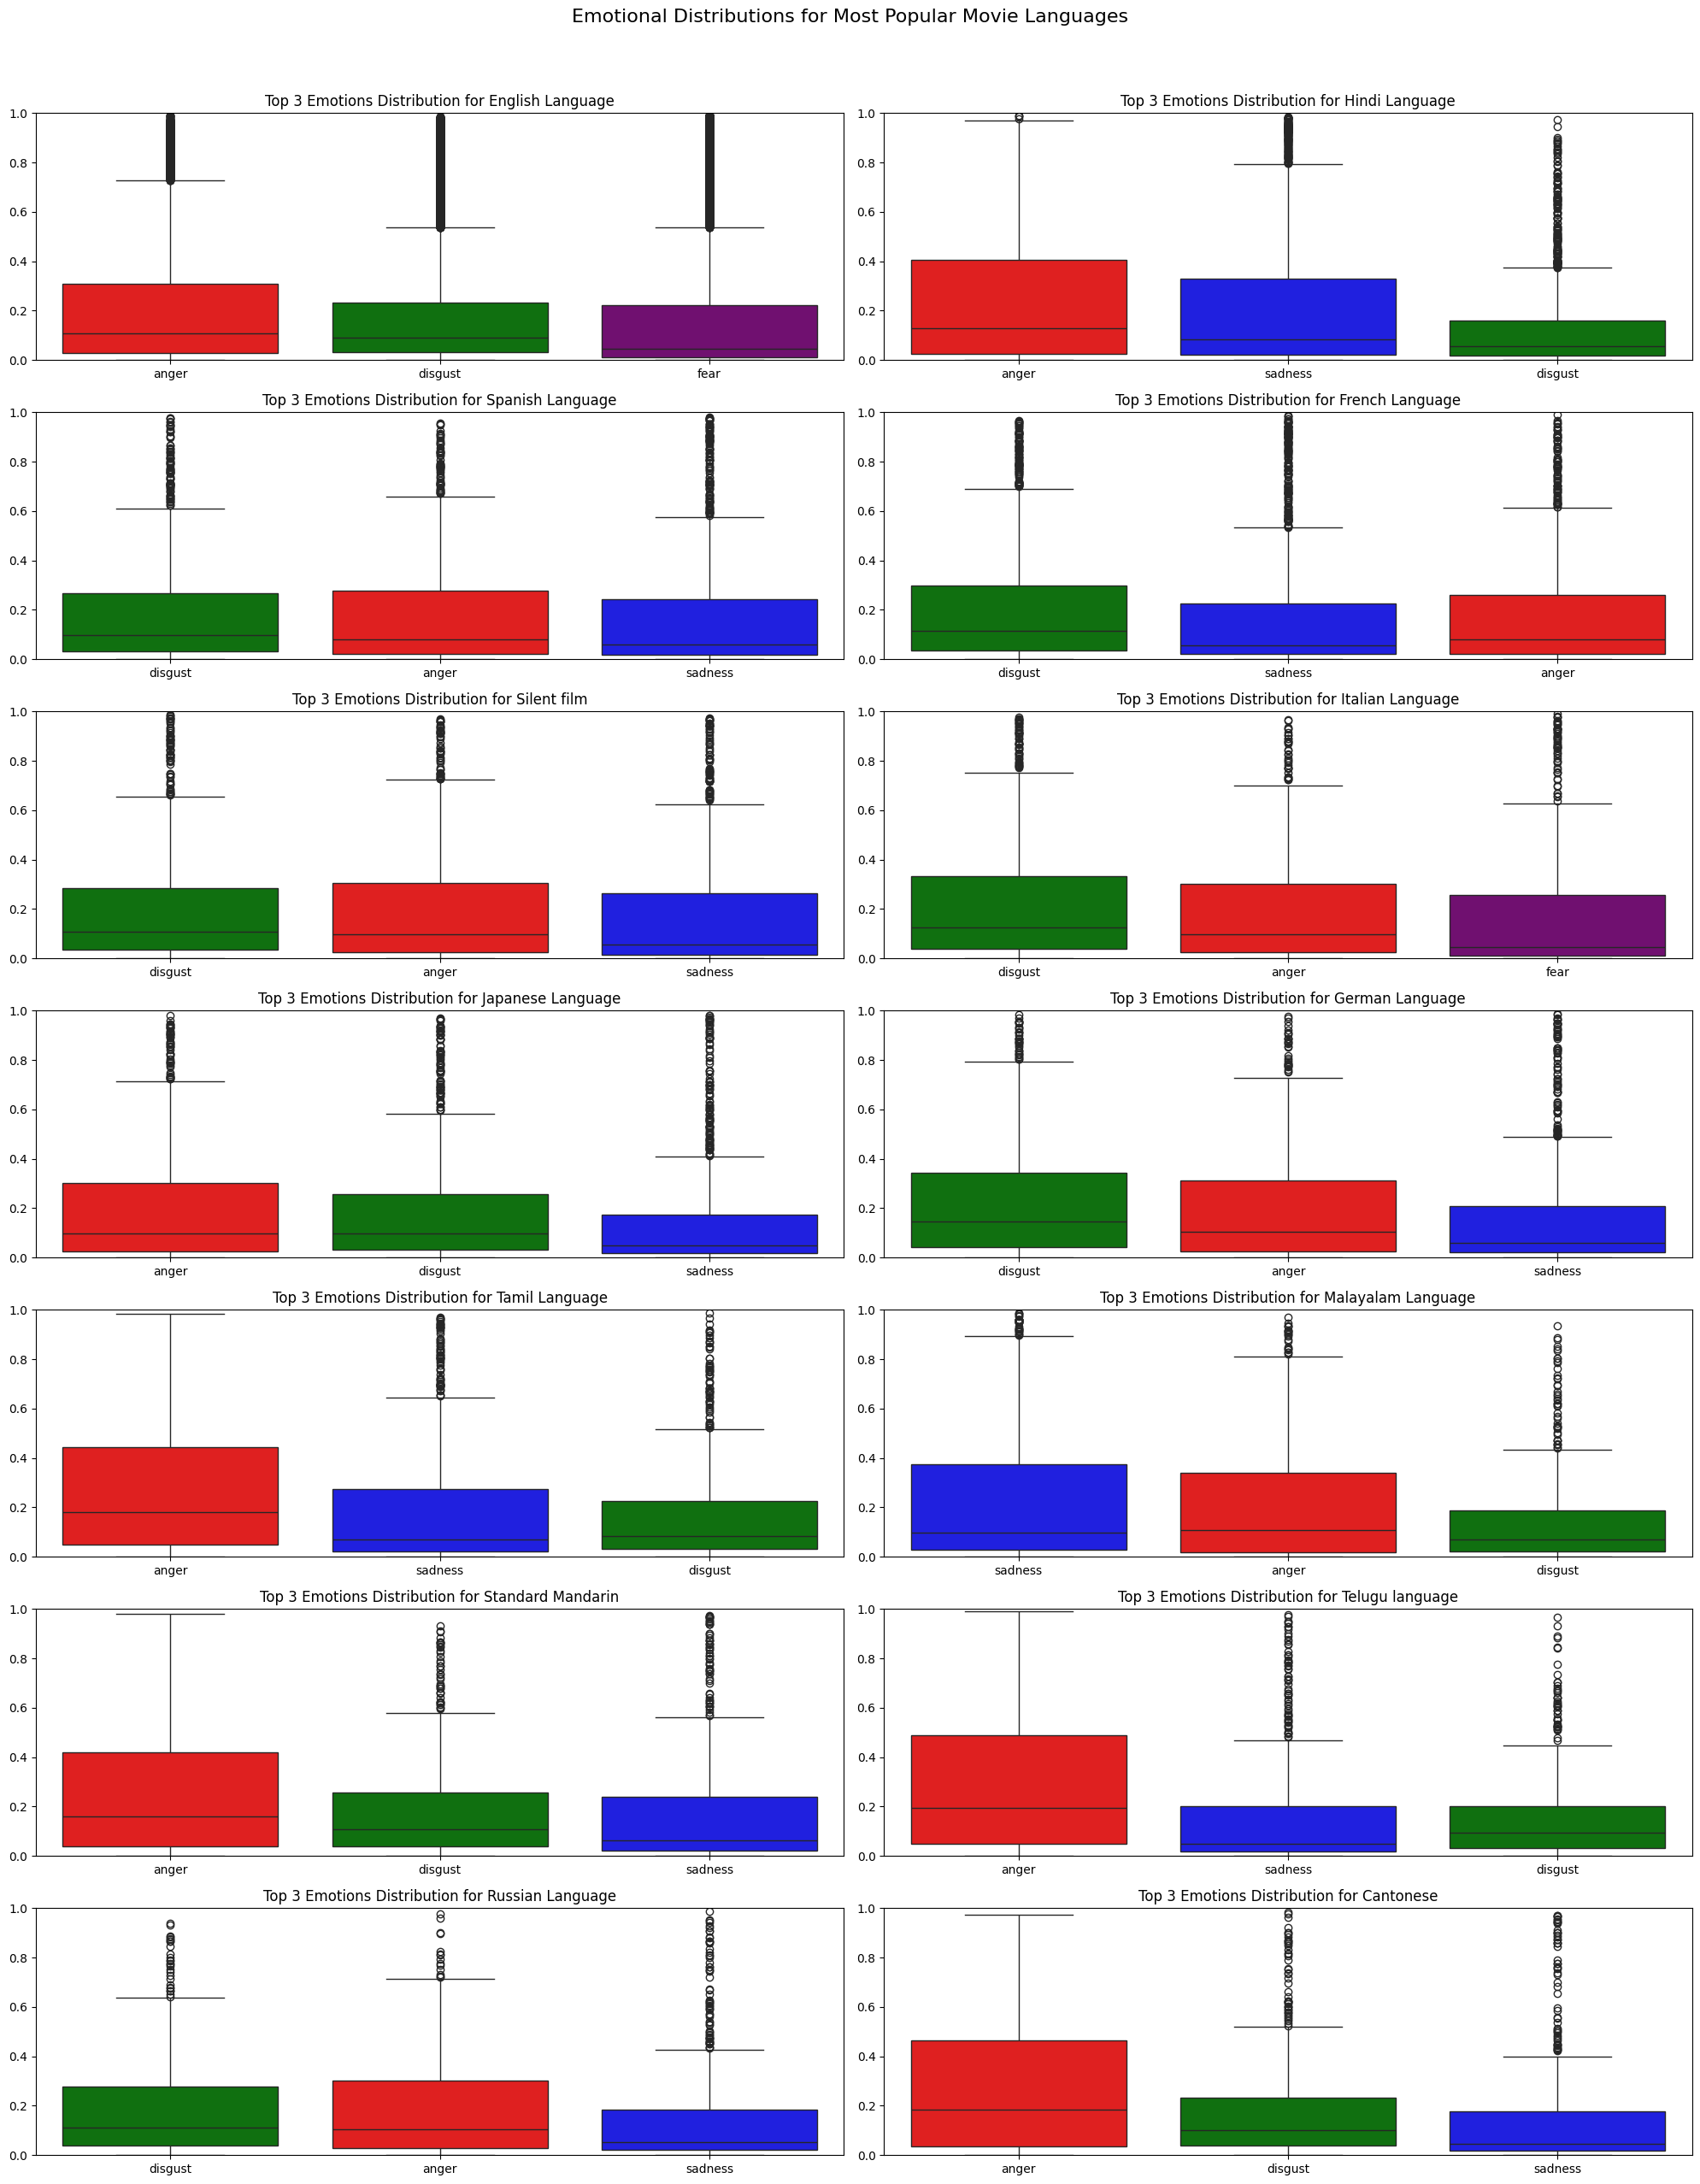

In [8]:
import seaborn as sns

# Define a color palette for the emotions
emotion_palette = {
  'anger': 'red',
  'disgust': 'green',
  'sadness': 'blue',
  'fear': 'purple',
  'joy': 'yellow',
  'surprise': 'orange'
}

# We analyze the emotions of the top 14 languages
top_languages = language_count[:14].index

# For each language, get all the movies that belong to it and plot emotion distributions
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 25))
axes = axes.flatten()

for i, lang in enumerate(top_languages):
  movies_in_lang = df[df['Languages'].apply(lambda x: lang in x)]
  distilbert_emotions = movies_in_lang['distilbert_emotions'].dropna()
  
  # Convert list of dicts to DataFrame for easier plotting
  distilbert_emotions_df = pd.DataFrame(list(distilbert_emotions))

  # Remove neutral emotion
  distilbert_emotions_df = distilbert_emotions_df.drop('neutral', axis=1)

  # Get top 3 emotions by mean value
  top_3_emotions_distilbert = distilbert_emotions_df.mean().nlargest(3).index
  
  # Plot boxplot for this language with only top 3 emotions
  sns.boxplot(data=distilbert_emotions_df[top_3_emotions_distilbert], ax=axes[i], palette=emotion_palette)
  axes[i].set_title(f'Top 3 Emotions Distribution for {lang}')
  axes[i].set_ylim(0, 1)

plt.suptitle('Emotional Distributions for Most Popular Movie Languages', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

def convert_to_percentage(emotions: dict) -> dict:
    """
    Convert emotional decimal values to percentages.
    """
    return {k: v * 100 for k, v in emotions.items()}

def prepare_data_for_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare the data for statistical analysis by:
    1. Expanding the language lists into separate rows
    2. Creating emotion columns from the dictionary
    3. Filtering for languages with sufficient data
    """

    df_new = df.copy()

    # Get rid of rows without emotion data
    df_new = df_new[df_new['distilbert_emotions'].apply(lambda x: isinstance(x, dict) and x != {})]

    # Multiply all the emotions by 100 so we can work with percentages
    df_new['distilbert_emotions'] = df_new['distilbert_emotions'].apply(convert_to_percentage)

     # Explode the Languages column to create separate rows for each language
    df_new = df_new.explode('Languages').reset_index(drop=True)

    # Create separate columns for each emotion
    for emotion in EMOTIONS:
        df_new[emotion] = df_new['distilbert_emotions'].apply(lambda x: x.get(emotion, np.nan))

    # Filter for languages with at least 100 movies
    language_counts = df_new['Languages'].value_counts()
    valid_languages = language_counts[language_counts >= 100].index
    df_filtered = df_new[df_new['Languages'].isin(valid_languages)]
    
    return df_filtered

REGRESSION_MODEL = "C(Languages, Treatment(reference='English Language'))"

def run_individual_regressions(df: pd.DataFrame):
    """
    Perform separate regression analyses for each emotion.
    """
    
    results = {}
    for emotion in EMOTIONS:
        model = sm.OLS.from_formula(f"{emotion} ~ {REGRESSION_MODEL}", data=df).fit()
        results[emotion] = {
            'r_squared': model.rsquared,
            'significant_effects': model.pvalues[model.pvalues < 0.05],
            'significant_params': model.params[model.pvalues < 0.05],
            'model': model
        }

    return results

# Prepare the data
df_analysis = prepare_data_for_analysis(df)

# Run all analyses
regression_results = run_individual_regressions(df_analysis)

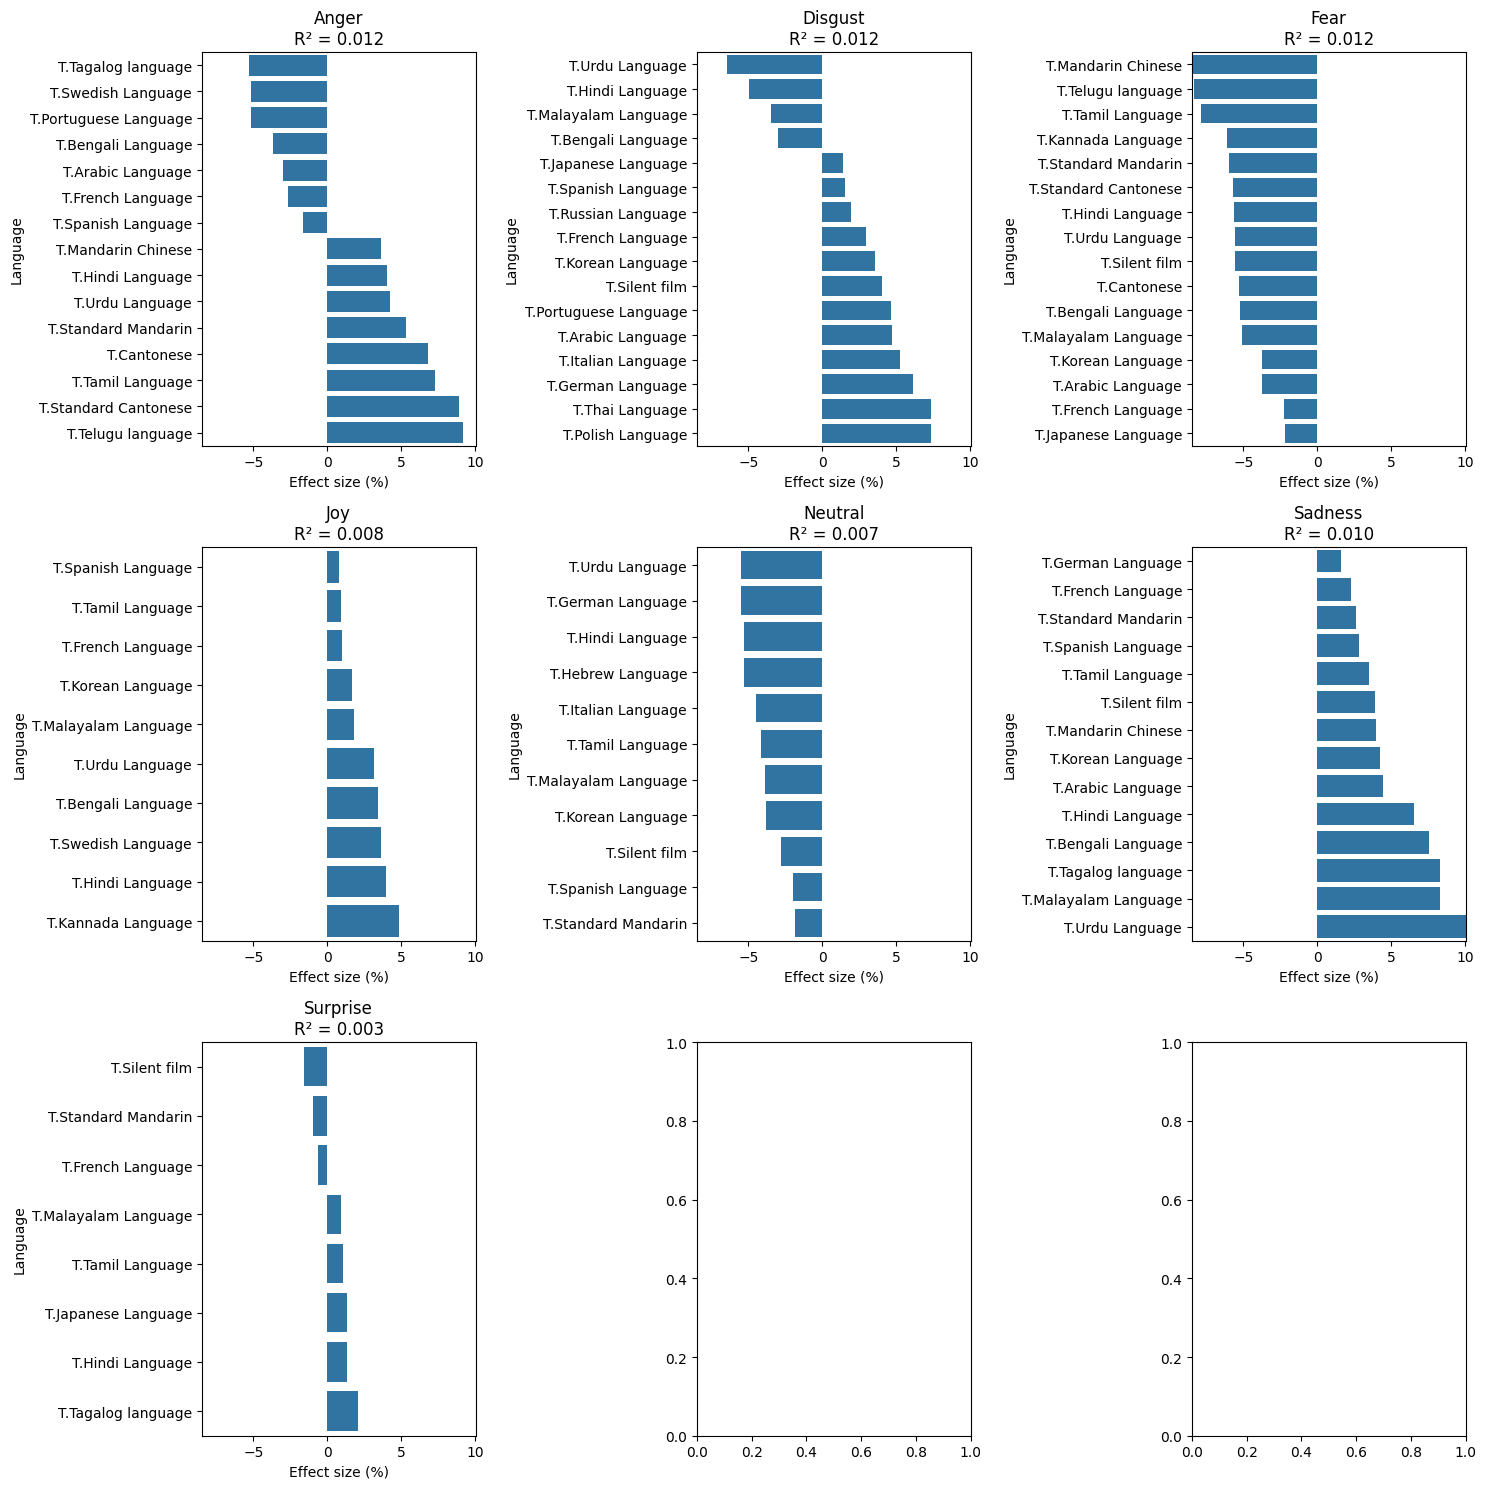

In [29]:
# Plot significant parameters for each emotion
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Find global min and max for consistent scale
all_params = []
for emotion in EMOTIONS:
    significant_params = regression_results[emotion]['significant_params']
    params_no_intercept = significant_params[1:]
    all_params.extend(params_no_intercept.values)
global_min, global_max = min(all_params), max(all_params)

for i, emotion in enumerate(EMOTIONS):
    if i < len(axes):
        significant_params = regression_results[emotion]['significant_params']
        
        params_no_intercept = significant_params[1:]  # don't include intercept
        params_sorted = params_no_intercept.sort_values(ascending=True)
        
        # Create bar plot
        sns.barplot(x=params_sorted.values, 
                   y=params_sorted.index.str.replace(f"{REGRESSION_MODEL}", '').str.strip('[]'), 
                   ax=axes[i])
        
        axes[i].set_title(f'{emotion.capitalize()}\nR² = {regression_results[emotion]["r_squared"]:.3f}')
        axes[i].set_xlabel('Effect size (%)')
        axes[i].set_ylabel('Language')
        axes[i].set_xlim(global_min, global_max)  # Set consistent scale

plt.tight_layout()


## Analysis of Regression Results

English was used as the reference category since it is both the normative and largest category.

### Overall effect size of language on emotional content is extremely low:
- The R² values are quite low (0.003-0.012) indicating language explains only a very small portion of the variance in emotional content
- This of course makes sense because the emotional content of a movie is MUCH more influenced factors such as the plot, the acting, the cinematography, etc.

### Some observed effects
In the fear emotion, all significant languages have a negative effect on fear compared to English. 

Likewise, in the joy and sadness emotions, all significant languages have a positive effect compared to English.

### Correlated emotions
OLS assumes that emotions from the same movie are treated as independent observations. However, this is probably not true because a more positive-film is more likely to have more positive emotions.